<a href="https://colab.research.google.com/github/ghrahul/ML-DL-PRACTICE/blob/master/Time%20Series/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

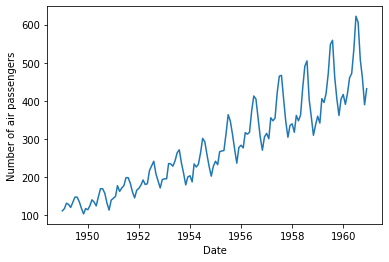

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

df = pd.read_csv('data.csv', parse_dates = ['Month'], index_col = ['Month'])
df.head()
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)

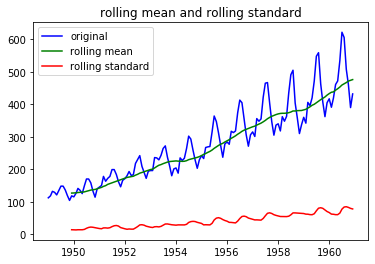

In [0]:
#before making the model we have to ensure that our series is stationary
#for making our series stationary we have to check if the series is stationary or not
#for stationarity check we can apply rolling statistics or ADF test


rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()

plt.plot(df, color= 'blue', label= 'original')
plt.plot(rolling_mean, color= 'green', label= 'rolling mean')
plt.plot(rolling_std, color= 'red', label = 'rolling standard')

plt.legend(loc = 'best')

plt.title("rolling mean and rolling standard")

plt.show()


#here the rolling mean and rolling standard increase with time therefore we can conclude that the series is not stationary 

In [0]:
#apply dickey fuller test

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['#Passengers'])

print(result)

print("ADF statistic: {}".format(result[0]))
print("P value: {}".format(result[1]))
print("critical values")
for key, value in result[4].items():
  print('\t{}: {}'.format(key, value))


# The ADF Statistic is far from the critical values and the p-value 
# is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

(0.815368879206047, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
ADF statistic: 0.815368879206047
P value: 0.991880243437641
critical values
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


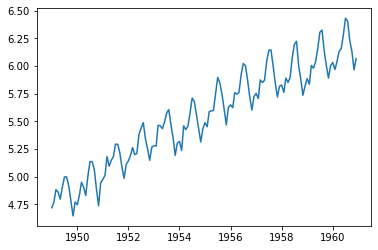

In [0]:
import numpy as np

df_log = np.log(df)
# print(df_log.head())
plt.plot(df_log)

In [0]:
def check_stationary(timeseries):
  result = adfuller(timeseries['#Passengers'])
  print("ADF statistic: {}".format(result[0]))
  print("P value: {}".format(result[1]))
  print("critical values")
  for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

  rolling_mean = timeseries.rolling(window=12).mean()
  rolling_std = timeseries.rolling(window=12).std()

  plt.plot(timeseries, color= 'blue', label= 'original')
  plt.plot(rolling_mean, color= 'green', label= 'rolling mean')
  plt.plot(rolling_std, color= 'red', label = 'rolling standard')

  plt.legend(loc = 'best')

  plt.title("rolling mean and rolling standard")

  plt.show()




ADF statistic: -3.162907991300857
P value: 0.022234630001243903
critical values
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


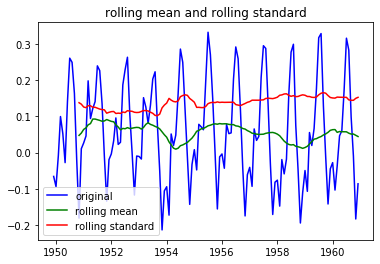

In [0]:
#transformation for making a series stationary BY SUBSTRACTING ROLLING MEAN

rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

check_stationary(df_log_minus_mean)

ADF statistic: -3.6012624201616723
P value: 0.005736938801511978
critical values
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


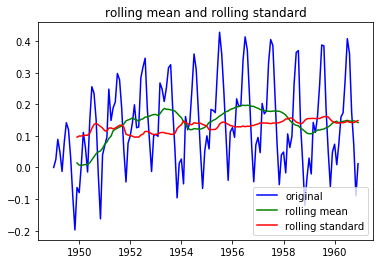

In [0]:
#applying exponential decay
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

check_stationary(df_log_exp_decay)




ADF statistic: -2.7171305983881284
P value: 0.0711205481508595
critical values
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


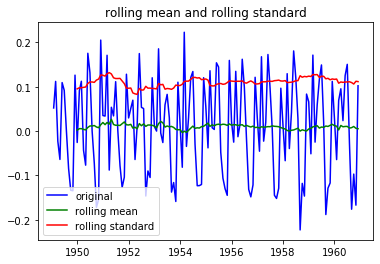

In [0]:
#When applying time shifting, we subtract every the point by the one that preceded it.

df_log_shift = df_log - df_log. shift()
df_log_shift.dropna(inplace=True)

check_stationary(df_log_shift)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


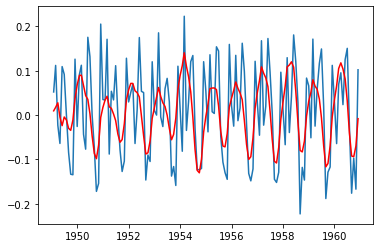

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

decomposition = seasonal_decompose(df_log)
model = ARIMA(df_log, (2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

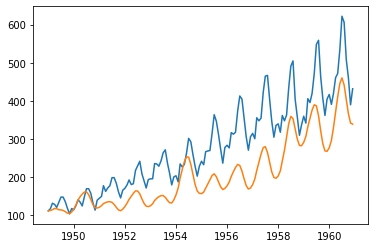

In [0]:
#model evaluation
prediction_arima_diff = pd.Series(results.fittedvalues, copy=True)
# print(prediction_arima_diff.head())
prediction_arima_diff_cumsum = prediction_arima_diff.cumsum()
# prediction_arima_diff_cumsum.head()

index = df_log.index
prediction_arima_log = pd.Series(df_log['#Passengers'].iloc[0], index=df_log.index) #first value
prediction_arima_log = prediction_arima_log.add(prediction_arima_diff_cumsum, fill_value=0) #add all other predictions_arima_diff_cumsum
prediction_arima = np.exp(prediction_arima_log)

plt.plot(df)
plt.plot(prediction_arima)



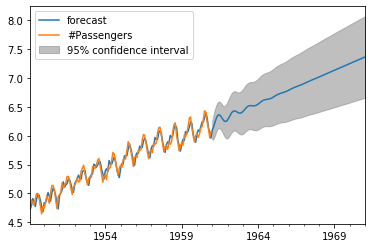

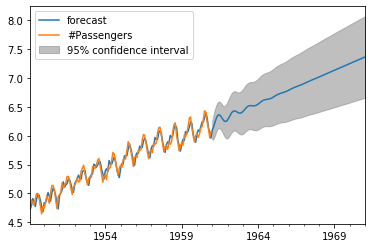

In [0]:
# Given that we have data going for every month going back 12 years and want to forecast the number of passengers for the next 10 years, 
# we use (12 x12)+ (12 x 10) = 264.

results.plot_predict(1,264)